# Figure 7: Monte Carlo Simulations

<div style="text-align: justify">
This code is used to create **Figure 7** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The Figure shows the effect of different types of noise an the detection uncertainty. The results are based on a Monte Carlo simulation explained in the paper.
</div>

## Imports

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from applefy.statistics.parametric import TTest
from applefy.statistics.bootstrapping import LaplaceBootstrapTest,\
    GaussianBootstrapTest
from applefy.statistics import gaussian_sigma_2_fpf, fpf_2_gaussian_sigma
from applefy.utils.file_handling import read_apples_with_apples_root

# Imports needed for the MC simulation
from applefy.utils.mc_simulations import draw_mc_sample
try:
    from parallel_sort import parallel_sort_inplace as sort_fast
    found_fast_sort = True
except ImportError:
    found_fast_sort = False
    sort_fast = np.sort

## Monte-Carlo Simulation

<div style="text-align: justify">
First we need to run the monte carlo simulation. This step is computationally very expensive. If you just want to reproduce the plot you can skip this part and [restore the results](07_Monte_Carlo_Simulations_PB_Laplace.ipynb#Alternative:-restore-the-results) from Zenodo.
</div>

In [2]:
# Set the number of CPU cores we want to use
num_cpus = 128

<div style="text-align: justify">
We want to test how acurate the bootstrap test and t-test are given different types of noise and samples sizes. For this we restore the [previously computed](../../02_user_documentation/03_bootstrapping.ipynb) lookup tables for the [LaplaceBootstrapTest](../../03_package/statistics.rst#applefy.statistics.bootstrapping.LaplaceBootstrapTest) and the [GaussianBootstrapTest](../../03_package/statistics.rst#applefy.statistics.bootstrapping.GaussianBootstrapTest).

In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.
</div>

In [3]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir/


In [4]:
# Setup the tests
test_bs_laplace = LaplaceBootstrapTest.construct_from_json_file(
    os.path.join(experiment_root, "lookup_tables/laplace_lookup_tables.csv"))
test_bs_laplace.m_num_cpus = num_cpus

test_bs_gauss = LaplaceBootstrapTest.construct_from_json_file(
    os.path.join(experiment_root, "lookup_tables/gaussian_lookup_tables.csv"))
test_bs_gauss.m_num_cpus = num_cpus

test_t = TTest(num_cpus=num_cpus)

Next we run the actual Monte-Carlo simulation. Since, we want to evaluate the tests (*test_bs_laplace*, *test_bs_gauss* and *test_t*) under different settings we define a function. 

The general steps of the simulation are as follows:
- For a given separation determine the number of noise observations (apertures) available.
- Draw samples form the distribution of choice (gaussian or laplacian in this case). Each sample contains *num_noise_observations -1* values for the noise and *one* value for the planet signal. In total we draw 1e9 monte-carlo samples.
- Apply all three tests on all 1e9 samples and save their p-values.
- Compare the test results with the actual FPF. A test is accurate if for e.g. a detection threshold 0.02, 2% of the 1e9 samples have a p-value <= 0.02.
- Translate the fpf back into gaussian sigmas.

In [5]:
def run_monte_carlo_simulations(
    separation,
    noise_distribution,
    noise_parameters,
    num_simulations,
    intervalls = 2):
    
    # The number of apertures we need for the given separation
    num_noise_observations = int(
        np.floor(2 * np.pi * separation)) - 1
    
    # lists to save the results
    p_values_laplace = []
    p_values_gauss = []
    p_values_ttest = []
    
    for i in range(intervalls):
        # 1.) Draw random noise with multiprocessing --------------
        samples_planet, samples_noise, shared_arr = draw_mc_sample(
            num_noise_observations,
            num_draws=int(num_simulations / intervalls),
            noise_distribution=noise_distribution,
            num_cores=num_cpus,
            loc_noise=noise_parameters[0],
            scale_noise=noise_parameters[1])
    
        # 2.) Run the different tests -----------------------------
        print("Calculationg p-values:", end = '')
        p_values_laplace.append(test_bs_laplace.test_2samp(
            noise_samples=samples_noise,
            planet_samples=samples_planet)[0])
        print(".", end = '')

        p_values_gauss.append(test_bs_gauss.test_2samp(
            noise_samples=samples_noise,
            planet_samples=samples_planet)[0])
        print(".", end = '')

        p_values_ttest.append(test_t.test_2samp(
            noise_samples=samples_noise,
            planet_samples=samples_planet)[0])
        print(".", end = '')
        print("[DONE]")
        
        # 3.) free the memory -------------------------------------
        shared_arr.unlink()
        shared_arr.close()
        del samples_planet
        del samples_noise
    
    # 4.) Merge the results
    p_values_laplace = np.concatenate(p_values_laplace)
    p_values_gauss = np.concatenate(p_values_gauss)
    p_values_ttest = np.concatenate(p_values_ttest)
    
    # 5.) calculate the fpf as a function of desired fpf ----------
    # sorting makes the evaluation a lot faster
    print("Sorting p-values...", end="")
    sort_fast(p_values_laplace)
    sort_fast(p_values_gauss)
    sort_fast(p_values_ttest)
    print("[DONE]")
    
    # 6.) set the target fpf thresholds given sigma values --------
    # between 0 and 5
    target_sigma = np.linspace(0, 5, 100)
    target_fpf = gaussian_sigma_2_fpf(target_sigma)

    # 7.) calculate the actual fpf and sigma values ---------------
    actual_fpf_bs_gauss = np.searchsorted(
        p_values_gauss, target_fpf) / len(p_values_gauss)
    actual_fpf_bs_laplace = np.searchsorted(
        p_values_laplace, target_fpf) / len(p_values_laplace)
    actual_fpf_ttest = np.searchsorted(
        p_values_ttest, target_fpf) / len(p_values_ttest)
    
    actual_sigma_bs_gauss = fpf_2_gaussian_sigma(
        actual_fpf_bs_gauss)
    actual_sigma_bs_laplace = fpf_2_gaussian_sigma(
        actual_fpf_bs_laplace)
    actual_sigma_ttest = fpf_2_gaussian_sigma(
        actual_fpf_ttest)
    
    # 8.) Save the results -----------------------------------------
    result_dict = dict(
        actual_sigma=np.concatenate(
            [actual_sigma_bs_gauss, 
             actual_sigma_bs_laplace,
             actual_sigma_ttest]),
        actual_fpf=np.concatenate(
            [actual_fpf_bs_gauss,
             actual_fpf_bs_laplace,
             actual_sigma_ttest]),
        target_sigma=np.concatenate([target_sigma]*3),
        target_fpf=np.concatenate([target_fpf] * 3),
        noise=[noise_distribution] * len(target_fpf) * 3,
        noise_location=[noise_parameters[0]] * len(target_fpf) * 3,
        noise_scale=[noise_parameters[1]] * len(target_fpf) * 3,
        separation=[separation] * len(target_fpf) * 3,
        model=["P-BS-Gaussian"] * len(target_fpf) + \
              ["P-BS-Laplace"] * len(target_fpf) + \
              ["ttest"] * len(target_fpf))
    
    return pd.DataFrame(result_dict)

Run the monte-carlo simulation for different settings.

In [ ]:
all_results = []

for tmp_separation in [20, 10, 8, 4, 2, 1]:
    for tmp_noise_distribution in ["gaussian", "laplace"]: 
        for tmp_noise_parameters in [(5, 5)]:  # (0, 1), 
            
            print("Start running models at: " + str(tmp_separation) + 
                  "\n noise: " + str(tmp_noise_distribution) +
                  "\n noise parameters: " + str(tmp_noise_parameters))

            tmp_results = run_monte_carlo_simulations(
                separation = tmp_separation,
                noise_distribution= tmp_noise_distribution,
                noise_parameters = tmp_noise_parameters,
                num_simulations = int(1e8))
            
            all_results.append(tmp_results)

Merge the results into one big table.

In [ ]:
combined_table = pd.concat(all_results).reset_index(drop=True)
combined_table

Save the results as a .csv file.

In [ ]:
combined_table.to_csv(
    os.path.join(
        experiment_root, 
        "70_results/Monte_Carlo_simulations/Combined_MC_simulation.csv"))

## Alternative: restore the results

Restore the results of the Monte-Carlo simulation. In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [6]:
experiment_root = read_apples_with_apples_root()

combined_table = pd.read_csv(
    os.path.join(experiment_root, 
                 "70_results/Monte_Carlo_simulations/Combined_MC_simulation.csv"),
    index_col=[0])

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir/


In [7]:
combined_table

,actual_sigma,actual_fpf,target_sigma,target_fpf,noise,noise_location,noise_scale,separation,model
0,0.000013,0.499995,0.000000,5.000000e-01,gaussian,0,1,20,P-BS-Gaussian
1,0.050517,0.479855,0.050505,4.798600e-01,gaussian,0,1,20,P-BS-Gaussian
2,0.101014,0.459770,0.101010,4.597712e-01,gaussian,0,1,20,P-BS-Gaussian
3,0.151520,0.439783,0.151515,4.397847e-01,gaussian,0,1,20,P-BS-Gaussian
4,0.202035,0.419945,0.202020,4.199505e-01,gaussian,0,1,20,P-BS-Gaussian
...,...,...,...,...,...,...,...,...,...
7195,4.419827,4.419827,4.797980,8.013697e-07,laplace,5,5,1,ttest
7196,4.474194,4.474194,4.848485,6.220402e-07,laplace,5,5,1,ttest
7197,4.528158,4.528158,4.898990,4.816530e-07,laplace,5,5,1,ttest
7198,4.579450,4.579450,4.949495,3.720315e-07,laplace,5,5,1,ttest


## Create the Plot

Define the colors we use along all plots.

In [8]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1]]

Select the data for the subplots at 2 $\lambda / D$

In [9]:
inner_results_gaussian = combined_table[(combined_table["separation"] == 2) & 
                                        (combined_table["noise"] == "gaussian") & 
                                        (combined_table["noise_location"] == 5)]
inner_results_gaussian = inner_results_gaussian.drop(["separation"], axis=1)

inner_results_laplace = combined_table[(combined_table["separation"] == 2) & 
                                       (combined_table["noise"] == "laplace") & 
                                       (combined_table["noise_location"] == 5)]
inner_results_laplace = inner_results_laplace.drop(["separation"], axis=1)

# the results at 8 lambda / D
outer_results_gaussian = combined_table[(combined_table["separation"] == 8) & 
                                        (combined_table["noise"] == "gaussian") & 
                                        (combined_table["noise_location"] == 5)]
outer_results_gaussian = outer_results_gaussian.drop(["separation"], axis=1)

outer_results_laplace = combined_table[(combined_table["separation"] == 8) & 
                                       (combined_table["noise"] == "laplace") & 
                                       (combined_table["noise_location"] == 5)]
outer_results_laplace = outer_results_laplace.drop(["separation"], axis=1)

A small function which plots one of the four settings we show in the figure.

In [10]:
def make_line_plot(axis_in,
                   result_table):
    
    # Draw the ttest results in the background
    sns.lineplot(
        x="target_sigma", y="actual_sigma", 
        hue="model", alpha=0.3,
        palette=[color_palette[0],],
        data=result_table[result_table["model"] == "ttest"], 
        lw=4, ax=axis_in)
    
    sns.lineplot(
        x="target_sigma", y="actual_sigma", 
        hue="model",
        palette=[color_palette[1],],
        data=result_table[result_table["model"] == "P-BS-Laplace"], 
        lw=2, ax=axis_in)
    
    sns.lineplot(
        x="target_sigma", y="actual_sigma", 
        hue="model", linestyle=(0, (5, 5)),
        palette=[color_palette[0],],
        data=result_table[result_table["model"] == "P-BS-Gaussian"],
        lw=2, ax=axis_in)

    axis_in.legend([],[], frameon=False)
    axis_in.grid()
    axis_in.set_xlim(1, 5)
    axis_in.set_ylim(1, 5)
    axis_in.set_xticks(np.arange(1, 5.5, 0.5))
    axis_in.set_yticks(np.arange(1, 5.5, 0.5))

Create the final plot.

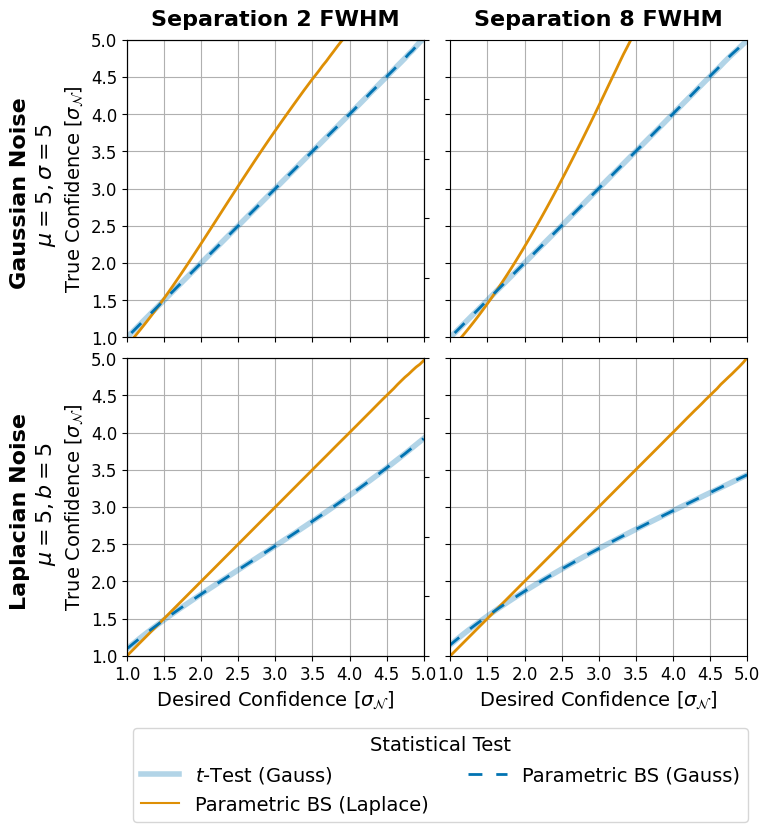

In [11]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False,
                 figsize=(8, 8))
gs0 = fig.add_gridspec(2, 2)
gs0.update(hspace=0.07, wspace=0.09)

ax_inner_sigma_g = fig.add_subplot(
    gs0[0, 0])
ax_outer_sigma_g = fig.add_subplot(
    gs0[0, 1], 
    sharex=ax_inner_sigma_g, 
    sharey=ax_inner_sigma_g)
ax_inner_sigma_l = fig.add_subplot(
    gs0[1, 0], 
    sharex=ax_inner_sigma_g, 
    sharey=ax_inner_sigma_g)
ax_outer_sigma_l = fig.add_subplot(
    gs0[1, 1], 
    sharex=ax_inner_sigma_g, 
    sharey=ax_inner_sigma_g)

# Plot the sigma comparison
# 1.) Inner Region
make_line_plot(ax_inner_sigma_g, inner_results_gaussian)
make_line_plot(ax_inner_sigma_l, inner_results_laplace)

# 2.) Outer Region
make_line_plot(ax_outer_sigma_g, outer_results_gaussian)
make_line_plot(ax_outer_sigma_l, outer_results_laplace)

# 3.) Set labels and titles
ax_inner_sigma_l.set_xlabel(
    "Desired Confidence [$\sigma_{\mathcal{N}}$]", size=14)
ax_outer_sigma_l.set_xlabel(
    "Desired Confidence [$\sigma_{\mathcal{N}}$]", size=14)
ax_inner_sigma_l.set_ylabel(
    "True Confidence [$\sigma_{\mathcal{N}}$]", size=14)
ax_inner_sigma_g.set_ylabel(
    "True Confidence [$\sigma_{\mathcal{N}}$]", size=14)

ax_outer_sigma_g.set_xlabel(None)
ax_outer_sigma_g.set_ylabel(None)
ax_outer_sigma_l.set_ylabel(None)
ax_inner_sigma_g.set_xlabel(None)

# x titles
ax_inner_sigma_g.set_title(
    "Separation 2 FWHM",
    fontsize=16, fontweight="bold", y=1.02)
ax_outer_sigma_g.set_title(
    "Separation 8 FWHM", 
    fontsize=16, fontweight="bold", y=1.02)

# Y titles
ax1 = ax_inner_sigma_g.twinx()
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.yaxis.set_label_position('left')
ax1.set_ylabel(
    "Gaussian Noise \n $\mu = 5, \sigma = 5$",
    size=16, fontweight="bold", labelpad=50)

ax1 = ax_inner_sigma_l.twinx()
plt.setp(ax1.get_yticklabels(), visible=False)
ax1.yaxis.set_label_position('left')
ax1.set_ylabel(
    "Laplacian Noise \n $\mu = 5, b = 5$", 
    size=16, fontweight="bold", labelpad=50)

# hide several ticks on subplots
plt.setp(ax_outer_sigma_l.get_yticklabels(), visible=False)
plt.setp(ax_outer_sigma_g.get_yticklabels(), visible=False)
plt.setp(ax_inner_sigma_g.get_xticklabels(), visible=False)
plt.setp(ax_outer_sigma_g.get_xticklabels(), visible=False)
ax_outer_sigma_l.tick_params(
    axis='both', which='major', labelsize=12)
ax_outer_sigma_g.tick_params(
    axis='both', which='major', labelsize=12)
ax_inner_sigma_g.tick_params(
    axis='both', which='major', labelsize=12)
ax_inner_sigma_l.tick_params(
    axis='both', which='major', labelsize=12)

# 4.) Legend
handles, labels = ax_outer_sigma_l.get_legend_handles_labels()

# For some reason the handles overwite the style and alpha
handles[0].set_alpha(0.3)
handles[0].set_lw(4)
handles[2].set_linestyle((0, (5, 5)))
handles[2].set_lw(2)

handles1 = [handles[0], handles[1], handles[2]]
labels1 = ['$t$-Test (Gauss)', 
           'Parametric BS (Laplace)', 
           'Parametric BS (Gauss)',]

leg1 = fig.legend(handles1, labels1, 
                  bbox_to_anchor=(0.12, -0.11), 
                  fontsize=14, 
                  title="Statistical Test",
                  loc='lower left', ncol=2)

plt.setp(leg1.get_title(), fontsize=14)

# 5.) Save the plot
fig.patch.set_facecolor('white')
plt.savefig("./07_Monte_Carlo_Parametric_BS.pdf",
            bbox_extra_artists=(leg1,), 
            bbox_inches='tight')